# PyEcosampling API Usage Demo

This notebook is a simple one frame iteration to the process of gaze sampling. Its main purpose is not to run a valid experiment, just demonstrate the functioning of the code.

### Running Whole Experiment

If you want to run the whole experiment execute the following bash command in the root directory:

```bash
$ python ecosampling
```


## Imports

The first cell bellow is setting the work directory, please dont change.

In [31]:
import os
if os.getcwd().split('/')[-1] == 'notebook':
    root_dir = os.path.dirname(os.path.abspath(os.path.curdir))
    os.chdir(root_dir + '/ecosampling/')
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/renatonobre/Desktop/Projects/AC_NI/INMCA_Nobre/ecosampling


Import libraries from ecosampling

In [2]:
import matplotlib.pyplot as plt

from action_selector import ActionSelector
from complexity import Complexity
from config import GeneralConfig, ProtoConfig, SaliencyConfig, ProtoConfig, IPConfig, ComplexityConfig, GazeConfig
from feature_map import FeatureMap
from frame_processor import FrameProcessor
from gaze_sampler import GazeSampler
from interest_points import IPSampler
from proto_parameters import ProtoParameters
from salience_map import SalienceMap
from utils.plotter import Plotter as plotter

Setting Up initial variables, and helper function. If this was to be a complete experiment, those variables would be update at each interaction with the system

In [3]:
def print_configurations(conf_class, conf_class_str):
    attrs = vars(conf_class)
    attrs_keys = [attr for attr in attrs if not attr.startswith('__')]
    print(f"{conf_class_str} Configurations:")
    for attr in attrs_keys:
        print(f"\t{attr}: {attrs[attr]}")

FRAME = 2
center_foa = GazeSampler(FrameProcessor()).start_foa
start_nu = GazeSampler(FrameProcessor()).start_nu
start_dir = 0


Running an experiment in pyecosampling is based on the config.py file. All the important values of the experiment are set there. Following are the values for the general configuration.

In [4]:
print_configurations(GeneralConfig, "General")

General Configurations:
	EXPERIMENT_TYPE: 3DLARK_SELFRESEMBLANCE
	OFFSET: 1
	TOTAL_OBSERVERS: 1
	FRAME_STEP: 2
	VIDEO_NAME: beverly01
	DIR_OFFSET: 310
	EXPERIMENT_DATA_FOLDER: demo/
	NN_IMG_START: 1
	NN_IMG_END: 90
	VERBOSE: False
	VISUALIZE_RESULTS: True
	SAVE_FOV_IMG: True
	SAVE_SAL_IMG: True
	SAVE_PROTO_IMG: True
	SAVE_IP_IMG: True
	SAVE_HISTO_IMG: True
	SAVE_FOA_IMG: True
	SAVE_FOA_ONFILE: True
	SAVE_COMPLEXITY_ONFILE: True
	PROJECT_ROOT: /Users/renatonobre/Desktop/Projects/AC_NI/INMCA_Nobre/ecosampling
	BASE_DIR: /Users/renatonobre/Desktop/Projects/AC_NI/INMCA_Nobre
	DATA_DIR: /Users/renatonobre/Desktop/Projects/AC_NI/INMCA_Nobre/data/
	FRAME_DIR: /Users/renatonobre/Desktop/Projects/AC_NI/INMCA_Nobre/data/demo/
	RESULTS_DIR: /Users/renatonobre/Desktop/Projects/AC_NI/INMCA_Nobre/results/beverly01/
	GENERATE_GIF: True


### A. Sampling the Natural Habitat

### A.0 Read Frame

Starting from the process of gaze sampling, there is the FrameProcessor class. Its main purpose is to provide functions for both opening and transforming the image frames. Specially, the FrameProcessor class has functions to create the windows size frames from images in the local directory, apply a foveated filtering to a frame, and reduce and resize a given frame. The way in which the PyEcosampling is designed, not only the current frames is read, but also the previous and the future frame, creating a 3 time-step frame. Additionally, this images are converted to gray-scale for the rest of the experiment. 


Frame Shape = (480, 640, 3)


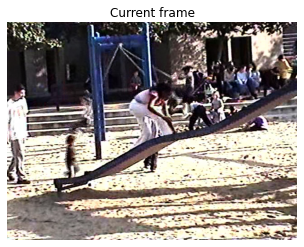

In [32]:
frame_sampling = FrameProcessor()
I = frame_sampling.read_frames(FRAME)
print(f"Frame Shape = {I.shape}")

fig, axs = plt.subplots()
plotter.plot_original_frame(axs, frame_sampling)

### A.1 Makes a Foveated Frame

Once the 3 time-step is created, the next step to perform is to apply a digital image processing technique denominated foveated imaging. The foveated imaging apply a Gaussian filter in the previous focus of attention, thus focusing the amount of detail in the current gaze location, and reducing the resolution of surrounding areas. 

Foveated Frame Shape = (480, 640, 3)


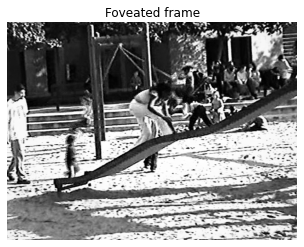

In [33]:
foveated_I = frame_sampling.foveated_imaging(center_foa, I)
print(f"Foveated Frame Shape = {foveated_I.shape}") 

fig, axs = plt.subplots()
plotter.plot_foveated_frame(axs, frame_sampling)

Additionally, the FrameProcessor class has also functions to reduce the frame to a desired size and resize it back to the original dimension. Those functions are extremely helpful in the creation of the feature map, in which, for computation purposes, required a reduced size image, while for visualization require to re-scale back to the original format.

### A.2 Compute Features of the Physical Landscape


After we have the foveated frame computed the next steps is to create a feature map, and use the feature map to create a salience map with the features found. 
In order to generate the salience, first PyEcosampling relies on its FeatureMap class to generate the features. This class is designed to be a wrapper to call backend feature computing methods and should be extended if future methods are to be implemented. In the PyEcosampling version created, the FeatureMap class calls Seo's 3D-LARK description features, to reproduce the static and space-time visual saliency by self-resemblance.

In [9]:
print_configurations(SaliencyConfig, "Saliency")

Saliency Configurations:
	WSIZE: 3
	WSIZE_T: 3
	LARK_ALPHA: 0.42
	LARK_H: 1
	LARK_SIGMA: 0.7
	S_LEVELS: 4


Reduced Frame Shape = (64, 64, 3)


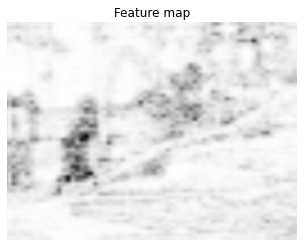

In [34]:
reduced_frames = frame_sampling.reduce_frames(foveated_I)
print(f"Reduced Frame Shape = {reduced_frames.shape}")
feature_map = FeatureMap()
foveated_feature_map = feature_map.compute_features(reduced_frames, frame_sampling)

fig, axs = plt.subplots()
plotter.plot_feature_map(axs, feature_map)

### A.3 Sample fovated Salience Map

After the LARK feature map calculation the Self-Resemblance backend is ready to create the salience map, and it does so through the template class SalienceMap. In SalienceMap, just as in FeatureMap, the methodology backend to create the map is called and should be extended for future methods.


In our approach the foveated 3D LARK feature map is used to create the Seo's et al. static and space-time self-resemblance salience. Overall, their method had state of the art performance on commonly used human eye fixation data, thus it was a good choice for the Ecosampling implementation and it was worth translating their work to PyEcosampling. 

Salience Map Shape = (480, 640)


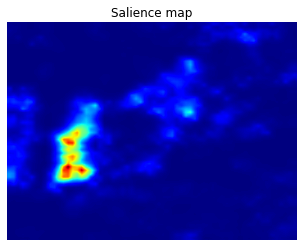

In [35]:
saliency_generator = SalienceMap()
saliency_map = saliency_generator.compute_salience(foveated_feature_map, frame_sampling)
print(f"Salience Map Shape = {saliency_map.shape}")

fig, axs = plt.subplots()
plotter.plot_saliency_map(axs, saliency_map)

### A.4 Sample Proto-Objects

After the salience map is generated, we can look for proto-objects in the map. 

The ProtoParameter class is responsible for creating a proto-object map and extracting proto-parameters. In a first step the class generates the raw patch map by threshold the normalized salience map so as to achieve 95% significance level for deciding whether the given saliency values are in the extreme tails. After that only a subset of best patches ranked through their size are selected. With those selected patches, ProtoParameters class is able to sample the proto-objects by computing the patch boundaries and fitting ellipses in the region. The technique used in the Ecosampling and hence this python version derives from Halir et al. numerically stable direct leat square fitting of ellipses.


It is worth mentioning that the proto-parameters step of the gaze sampling is not mandatory. If the user desires to not execute it, the user can opt to skip it and only sample interest points from landscape.

In [14]:
print_configurations(ProtoConfig, "Proto-Objects")


Proto-Objects Configurations:
	PROTO: True
	N_BEST_PROTO: 15


Proto-objects Found: 15


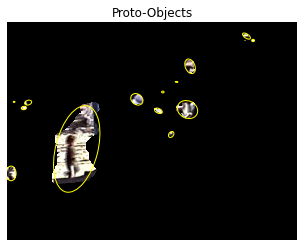

In [36]:
proto_params = ProtoParameters()
num_proto = proto_params.sample_proto_objects(saliency_map)
print(f"Proto-objects Found: {num_proto}")

fig, axs = plt.subplots()
plotter.plot_proto_objects(axs, frame_sampling, proto_params, num_proto)

### A.5 Sampling Interest Points / Preys

Now that we have proto-objects, the system can sample interest points. In PyEcosampling the IPSampler class is responsible for sampling those points. Overall, the class control the sampling of interest points. If there is no proto-objects, it will sample only from the landscape. If there are proto-objects, the user can choose to sample from both or just one.


Sampling points from the proto-objects corresponds to draw sample from a multivariate distribution, which will eventually, generate clusters of interest points, one cluster for each patch. On the other hand, sampling points from the landscape involves in sampling IPs directly from points weighted according to their salience, and for each sample set a scale by drawing from uniform distribution oven a given configuration scale. Thus being able to generate IPs both from the proto-objects and directly from the salience map.

In [17]:
def sample_ips(sample_landscape):
    IPConfig.WITH_PERTURBATION = sample_landscape
    if sample_landscape:
        print("Results with Landscape Sampling and Proto-objects\n")
    else:
        print("Results only with Proto-objects\n")
    ip_sampler = IPSampler()
    sampled_points_coord = ip_sampler.interest_point_sample(num_proto, proto_params, saliency_map)
    print(f"X-Axis Sampled Points Shape: {sampled_points_coord[0].shape}")
    print(f"Y-Axis Sampled Points Shape: {sampled_points_coord[1].shape}")
    print(f"Single Point Coords: {sampled_points_coord[0][0]}, {sampled_points_coord[0][1]}")
    return ip_sampler, sampled_points_coord

print_configurations(IPConfig, "Interest Points")

Interest Points Configurations:
	TYPE: SelfResemblance
	SCALE: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
	MAX_POINTS: 80
	WEIGHTED_SAMPLING: True
	WEIGHTED_SCALE: 0
	N_POINTS: 0
	WINDOW_SIZE: 7
	WITH_PERTURBATION: True
	X_BIN_SIZE: 20
	Y_BIN_SIZE: 20


#### IPS with only proto-objects

Results only with Proto-objects

X-Axis Sampled Points Shape: (239,)
Y-Axis Sampled Points Shape: (239,)
Single Point Coords: 540.330815019357, 525.7909481227701


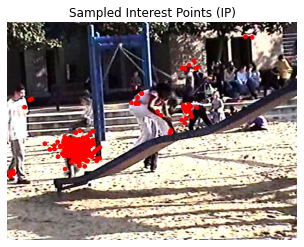

In [19]:
_, sampled_points_coord = sample_ips(sample_landscape=False)
fig, axs = plt.subplots()
plotter.plot_interest_points(axs, frame_sampling, sampled_points_coord)

#### IPS with proto-objects and landscape

Results with Landscape Sampling and Proto-objects

X-Axis Sampled Points Shape: (319,)
Y-Axis Sampled Points Shape: (319,)
Single Point Coords: 513.5610969986157, 525.3384196659395


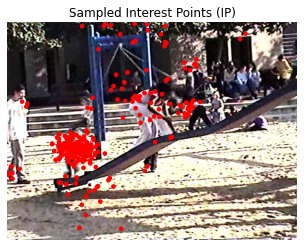

In [20]:
ip_sampler, sampled_points_coord = sample_ips(sample_landscape=True)
fig, axs = plt.subplots()
plotter.plot_interest_points(axs, frame_sampling, sampled_points_coord)

## B Sampling The Appropriate Ocolumotor Action

### B.1 Evaluating Complexity of the Scene

Once all the interest points are set, we are able to represent the IPS as a histogram of the spatio-temporal configuration of the landscape. Ecosampling, base this idea on the landscape entropy determined by dispersion or concentration of food items or preys. Therefore, generalizing this approach, Ecosampling is able to capture the time-varying configurational complexity of interest points within the landscape.

Histmat Shape: (24, 32)
Total Samples: 319
Total Bins: 768


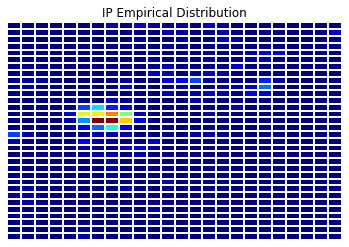

In [21]:
hist_mat, n_samples, n_bins = ip_sampler.histogram_ips(frame_sampling, sampled_points_coord)
print(f"Histmat Shape: {hist_mat.shape}")
print(f"Total Samples: {int(n_samples)}")
print(f"Total Bins: {n_bins}")


fig, axs = plt.subplots()
plotter.plot_empirical_dists(axs, ip_sampler.show_hist)

### B.1.2 Evaluate Complexity C(t)

Considering the generated empirical distribution of proto-objects and landscape's interest points, the next step on the process is to compute its spatial configuration complexity. The main reason for computing the spatial complexity is related to the action sampling process. Low complexity scenarios usually lead to longer flights, while at the edge of order or disorder more complex and mixed behaviors take place.

In the case of a time-varying visual landscape, a crowded scene with many people moving represents a disordered system (high entropy, low order) as opposed to a static scene where no events take place (low entropy, high order).

In [22]:
print_configurations(ComplexityConfig, "Complexity")

Complexity Configurations:
	TYPE: SDL
	EPS: 0.004


In [23]:
complexity_evaluator = Complexity()
order, disorder, complexity = complexity_evaluator.compute_complexity(hist_mat, n_samples, n_bins)
print(f"Order: {order}")
print(f"Disorder: {disorder}")
print(f"Complexity: {complexity}")

Order: 0.39929449968957786
Disorder: 0.6007055003104221
Complexity: 0.23985840220722757


### B.2. Action Selection via Landscape Complexity


Boccignone's Ecosampling defines three possible events that will eventually be identified to provide the gist of the spatio-temporal habitat: ordered dynamics, edge dynamics, and disordered dynamics, each biasing the process toward a specific gaze shift behavior. The ActionSelector class is responsible for reading the order, disorder, complexity, values, update the dirichlet hyper-parameters and sample the appropriate gaze action, which corresponds to the $\alpha$, $\beta$, $\delta$ and $\gamma$ values of a $\alpha$-stable distribution.

Summing up, the action sampling step corresponds to: i) compute the complexity of the landscape as a function of sampled interest points; ii) update accordingly the dirichlet hyper-parameters; iii) sample the gaze-shift action from a multinomial distribution using the resulting dirchlet $\pi$ probability.


In [24]:
# Starting Nu value
nu = start_nu
action_sampler = ActionSelector(disorder, order, complexity)
nu, z = action_sampler.select_action(nu)

print(f"NU Vector {nu}")
print(f"Sample Action {z}")

NU Vector [1. 1. 2.]
Sample Action [0]


## C Sampling The Gaze Shift

In [25]:
print_configurations(GazeConfig, "Gaze")

Gaze Configurations:
	FIRST_FOA_ON_CENTER: True
	SIMPLE_ATTRACTOR: False
	NMAX: 10
	NUM_INTERNALSIM: 100
	MAX_NUMATTEMPTS: 5
	ALPHA_STABLE: [2.0, 1.6, 1.4]
	GAMMA_STABLE: [3.78, 22, 60]
	BETA_STABLE: [1, 1, 1]
	DELTA_STABLE: [9, 60, 250]


Final FOA: [262. 245.]
New Dir: (1, 100)


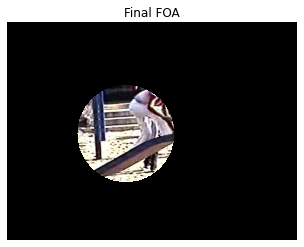

In [37]:
pred_foa = center_foa
dir_old = start_dir
gaze_sampler = GazeSampler(frame_sampling, proto_params, 
                           ip_sampler, hist_mat, num_proto)

final_foa, dir_new = gaze_sampler.sample_gaze_shift(z, pred_foa, dir_old)
print(f"Final FOA: {final_foa}")
print(f"New Dir: {dir_new.shape}")


fig, axs = plt.subplots()
plotter.plot_sampled_FOA(axs, frame_sampling, gaze_sampler)

#### IPs complete visualization

It is worth noting that the IPs are the red dots in the picture while the yellow and green dots represents both all candidates and the maximum focus of attention.

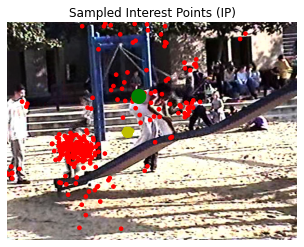

In [27]:
# Complete IPs
fig, axs = plt.subplots()
plotter.plot_interest_points(axs, frame_sampling, sampled_points_coord, gaze_sampler)